# DTI Models

## Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torchvision.models as models
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, utils, datasets
from torch.utils.data import DataLoader
from datetime import datetime

import nilearn.image as nim
import nilearn.plotting as nip
from nibabel.nifti1 import Nifti1Image

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("../scripts")

import dti_model as dm

from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

In [3]:
# im = nim.load_img("/mnt/datasets/PPMI/dti/ppmi_dti_control/PPMI_3104_MR_DTI_gated__br_raw_20110406110628525_2_S103319_I226395.nii")
# imdata = im.get_fdata().reshape(1, 72, 116, 116).squeeze()
# imdata2 = np.moveaxis(im.get_fdata(), 2, 0).squeeze()
# print(imdata.shape, imdata2.shape)
#vgg(torch.from_numpy(imdata.astype(np.float32)))

## Setup the DataBunch

In [7]:
train_data = "/home/eager/modeling-parkinsons/data/training/dti/train"
val_data = "/home/eager/modeling-parkinsons/data/training/dti/valid"

tfms = transforms.Compose([
    transforms.Lambda(lambda x: np.moveaxis(x, -1, 0).astype(np.float32)),
    transforms.Lambda(lambda x: torch.from_numpy(x))
])

train_dataset = datasets.DatasetFolder(train_data, dm.load_nifti_img, extensions=(".nii",), transform=tfms)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)

val_dataset = datasets.DatasetFolder(val_data, dm.load_nifti_img, extensions=(".nii",), transform=tfms)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=2)

In [5]:
train_dataset[0][0].shape

torch.Size([72, 116, 116])

In [6]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [7]:
def show_batch(imgs, labels):
    for i, (img, label) in enumerate(zip(imgs, labels)):
        nip.plot_img(Nifti1Image(img.permute(1, 2, 0).numpy(), affine=np.eye(4)), title=str(label.item()))

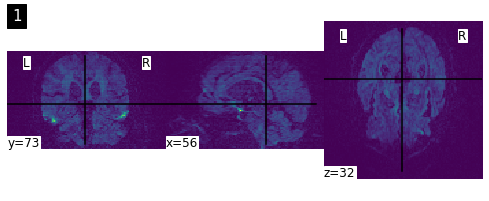

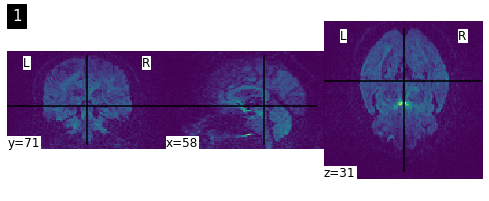

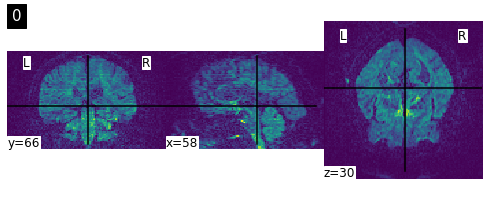

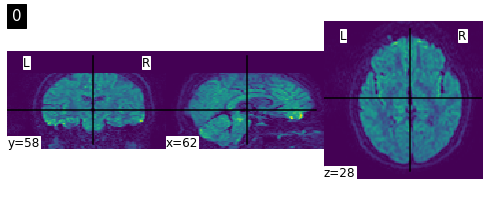

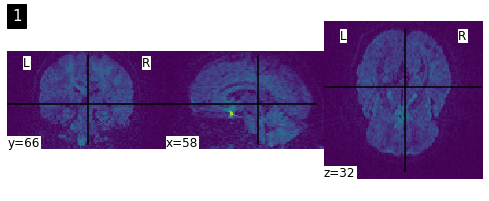

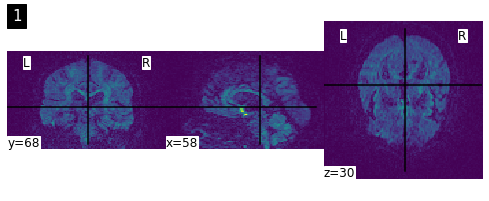

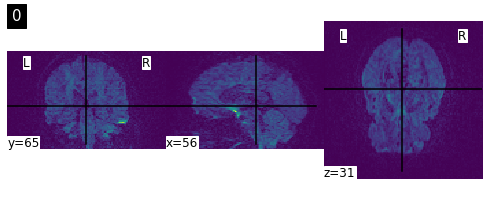

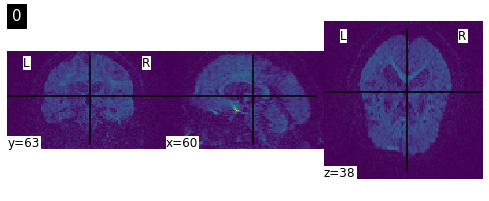

In [8]:
show_batch(images, labels)

In [54]:
# setup model
vgg = models.vgg16_bn(pretrained=False)
vgg.features._modules['0'] = nn.Conv2d(72, 64, 3)
vgg.classifier._modules['6'] = nn.Linear(4096, 2)

In [52]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(72, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fal

In [53]:
crit = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.001, weight_decay=0.1)
save_base = f"../vgg16-{datetime.now().isoformat()}"

vgg = vgg.cuda()

for epoch in range(5):
    running_loss = 0.0
    running_preds = []
    running_targs = []
    
    vgg.train()
    for i, data in tqdm(enumerate(train_loader)):
        inputs, labels = data
        
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        opt.zero_grad()
        
        outputs = vgg(inputs)
        loss = crit(outputs, labels)
        loss.backward()
        opt.step()
        
        running_loss += loss.item()
        
        preds = F.softmax(outputs.cpu().detach(), dim=1).numpy()[:, 1]
        targ = labels.cpu().detach().numpy()
        
        running_preds.extend(preds)
        running_targs.extend(targ)
        
        if i % 200 == 199:
            running_preds = np.array(running_preds)
            running_targs = np.array(running_targs)
            auc = roc_auc_score(running_targs, running_preds)
            acc = accuracy_score(running_targs, running_preds > 0.5)
            
            print("[epoch={}, minibatch={}] loss={:0.6f}, acc={:0.4f}, auc={:0.4f}".format(
                epoch,
                i + 1,
                running_loss / 200.0,
                acc,
                auc
            ))
            running_loss = 0.0
            running_preds = []
            running_targs = []
            
    
    with torch.no_grad():
        vgg.eval()
        print(f"=== [epoch={epoch}] evaluation === ")
        
        running_preds_val = []
        running_targs_val = []
        running_loss_val = 0.0
        
        for i, data in tqdm(enumerate(val_loader)):
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = vgg(inputs)
            loss = crit(outputs, labels)

            preds = F.softmax(outputs.cpu().detach(), dim=1).numpy()[:, 1]
            targ = labels.cpu().detach().numpy()

            running_loss_val += loss.item()
            running_preds_val.extend(preds)
            running_targs_val.extend(targ)
            
        running_preds_val = np.array(running_preds_val)
        running_targs_val = np.array(running_targs_val)
        auc_val = roc_auc_score(running_targs_val, running_preds_val)
        acc_val = accuracy_score(running_targs_val, running_preds_val > 0.5)
            
        print("[epoch={}] loss={:0.6f}, acc={:0.4f}, auc={:0.4f}".format(
            epoch,
            running_loss_val / len(running_preds_val),
            acc_val,
            auc_val
        ))
        
        torch.save(vgg.state_dict(), f"{save_base}-epoch-{epoch}.pth")

[epoch=0, minibatch=200] loss=3.049224, acc=0.4738, auc=0.5104
[epoch=0, minibatch=400] loss=0.688628, acc=0.5637, auc=0.5164
[epoch=0, minibatch=600] loss=0.687213, acc=0.5700, auc=0.5659
[epoch=0, minibatch=800] loss=0.688044, acc=0.5600, auc=0.5425
[epoch=0, minibatch=1000] loss=0.686916, acc=0.5694, auc=0.5821
[epoch=0, minibatch=1200] loss=0.687788, acc=0.5613, auc=0.5251
[epoch=0, minibatch=1400] loss=0.684859, acc=0.5831, auc=0.5207
[epoch=0, minibatch=1600] loss=0.683508, acc=0.5869, auc=0.4821
[epoch=0, minibatch=1800] loss=0.687388, acc=0.5581, auc=0.4818
[epoch=0, minibatch=2000] loss=0.685044, acc=0.5731, auc=0.4687
[epoch=0, minibatch=2200] loss=0.685823, acc=0.5669, auc=0.4762
[epoch=0, minibatch=2400] loss=0.686960, acc=0.5594, auc=0.4629
[epoch=0, minibatch=2600] loss=0.684915, acc=0.5719, auc=0.4910
[epoch=0, minibatch=2800] loss=0.684910, acc=0.5706, auc=0.4589
[epoch=0, minibatch=3000] loss=0.690490, acc=0.5369, auc=0.4852
[epoch=0, minibatch=3200] loss=0.685562, acc


[epoch=0] loss=0.042979, acc=0.5563, auc=0.4869


[epoch=1, minibatch=200] loss=0.687802, acc=0.5537, auc=0.4724
[epoch=1, minibatch=400] loss=0.684608, acc=0.5731, auc=0.4769
[epoch=1, minibatch=600] loss=0.684111, acc=0.5756, auc=0.5085
[epoch=1, minibatch=800] loss=0.690365, acc=0.5375, auc=0.4974
[epoch=1, minibatch=1000] loss=0.684961, acc=0.5706, auc=0.4648
[epoch=1, minibatch=1200] loss=0.687155, acc=0.5575, auc=0.4680
[epoch=1, minibatch=1400] loss=0.682491, acc=0.5850, auc=0.4823


KeyboardInterrupt: 

In [5]:
#torch.save(vgg.state_dict(), "../vgg16_dti_05-10-2020_18:22.pth")

model_dir = "../models/vgg16-2020-05-10T19:36:15.071174-epoch-0.pth"
weights = torch.load(model_dir)
vgg = models.vgg16(pretrained=False)
vgg.features._modules['0'] = nn.Conv2d(72, 64, 3)
vgg.classifier._modules['6'] = nn.Linear(4096, 2)
vgg.load_state_dict(weights)

<All keys matched successfully>

In [8]:
test_data = "/home/eager/modeling-parkinsons/data/test"

test_dataset = datasets.DatasetFolder(test_data, dm.load_nifti_img, extensions=(".nii",), transform=tfms)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

In [10]:
crit = nn.CrossEntropyLoss()

with torch.no_grad():
    vgg = vgg.cuda()
    vgg.eval()
    print(f"=== TESTING evaluation === ")

    running_preds_test = []
    running_targs_test = []
    running_loss_test = 0.0

    for i, data in tqdm(enumerate(test_loader)):
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        outputs = vgg(inputs)
        loss = crit(outputs, labels)

        preds = F.softmax(outputs.cpu().detach(), dim=1).numpy()[:, 1]
        targ = labels.cpu().detach().numpy()

        running_loss_test += loss.item()
        running_preds_test.extend(preds)
        running_targs_test.extend(targ)

    running_preds_test = np.array(running_preds_test)
    running_targs_test = np.array(running_targs_test)
    auc_test = roc_auc_score(running_targs_test, running_preds_test)
    acc_test = accuracy_score(running_targs_test, running_preds_test > 0.5)

    print("[testing] loss={:0.6f}, acc={:0.4f}, auc={:0.4f}".format(
        running_loss_test / len(running_preds_test),
        acc_test,
        auc_test
    ))

=== TESTING evaluation === 



[testing] loss=0.041053, acc=0.6164, auc=0.6971


Text(0.5, 374.1666666666665, 'predicted class')

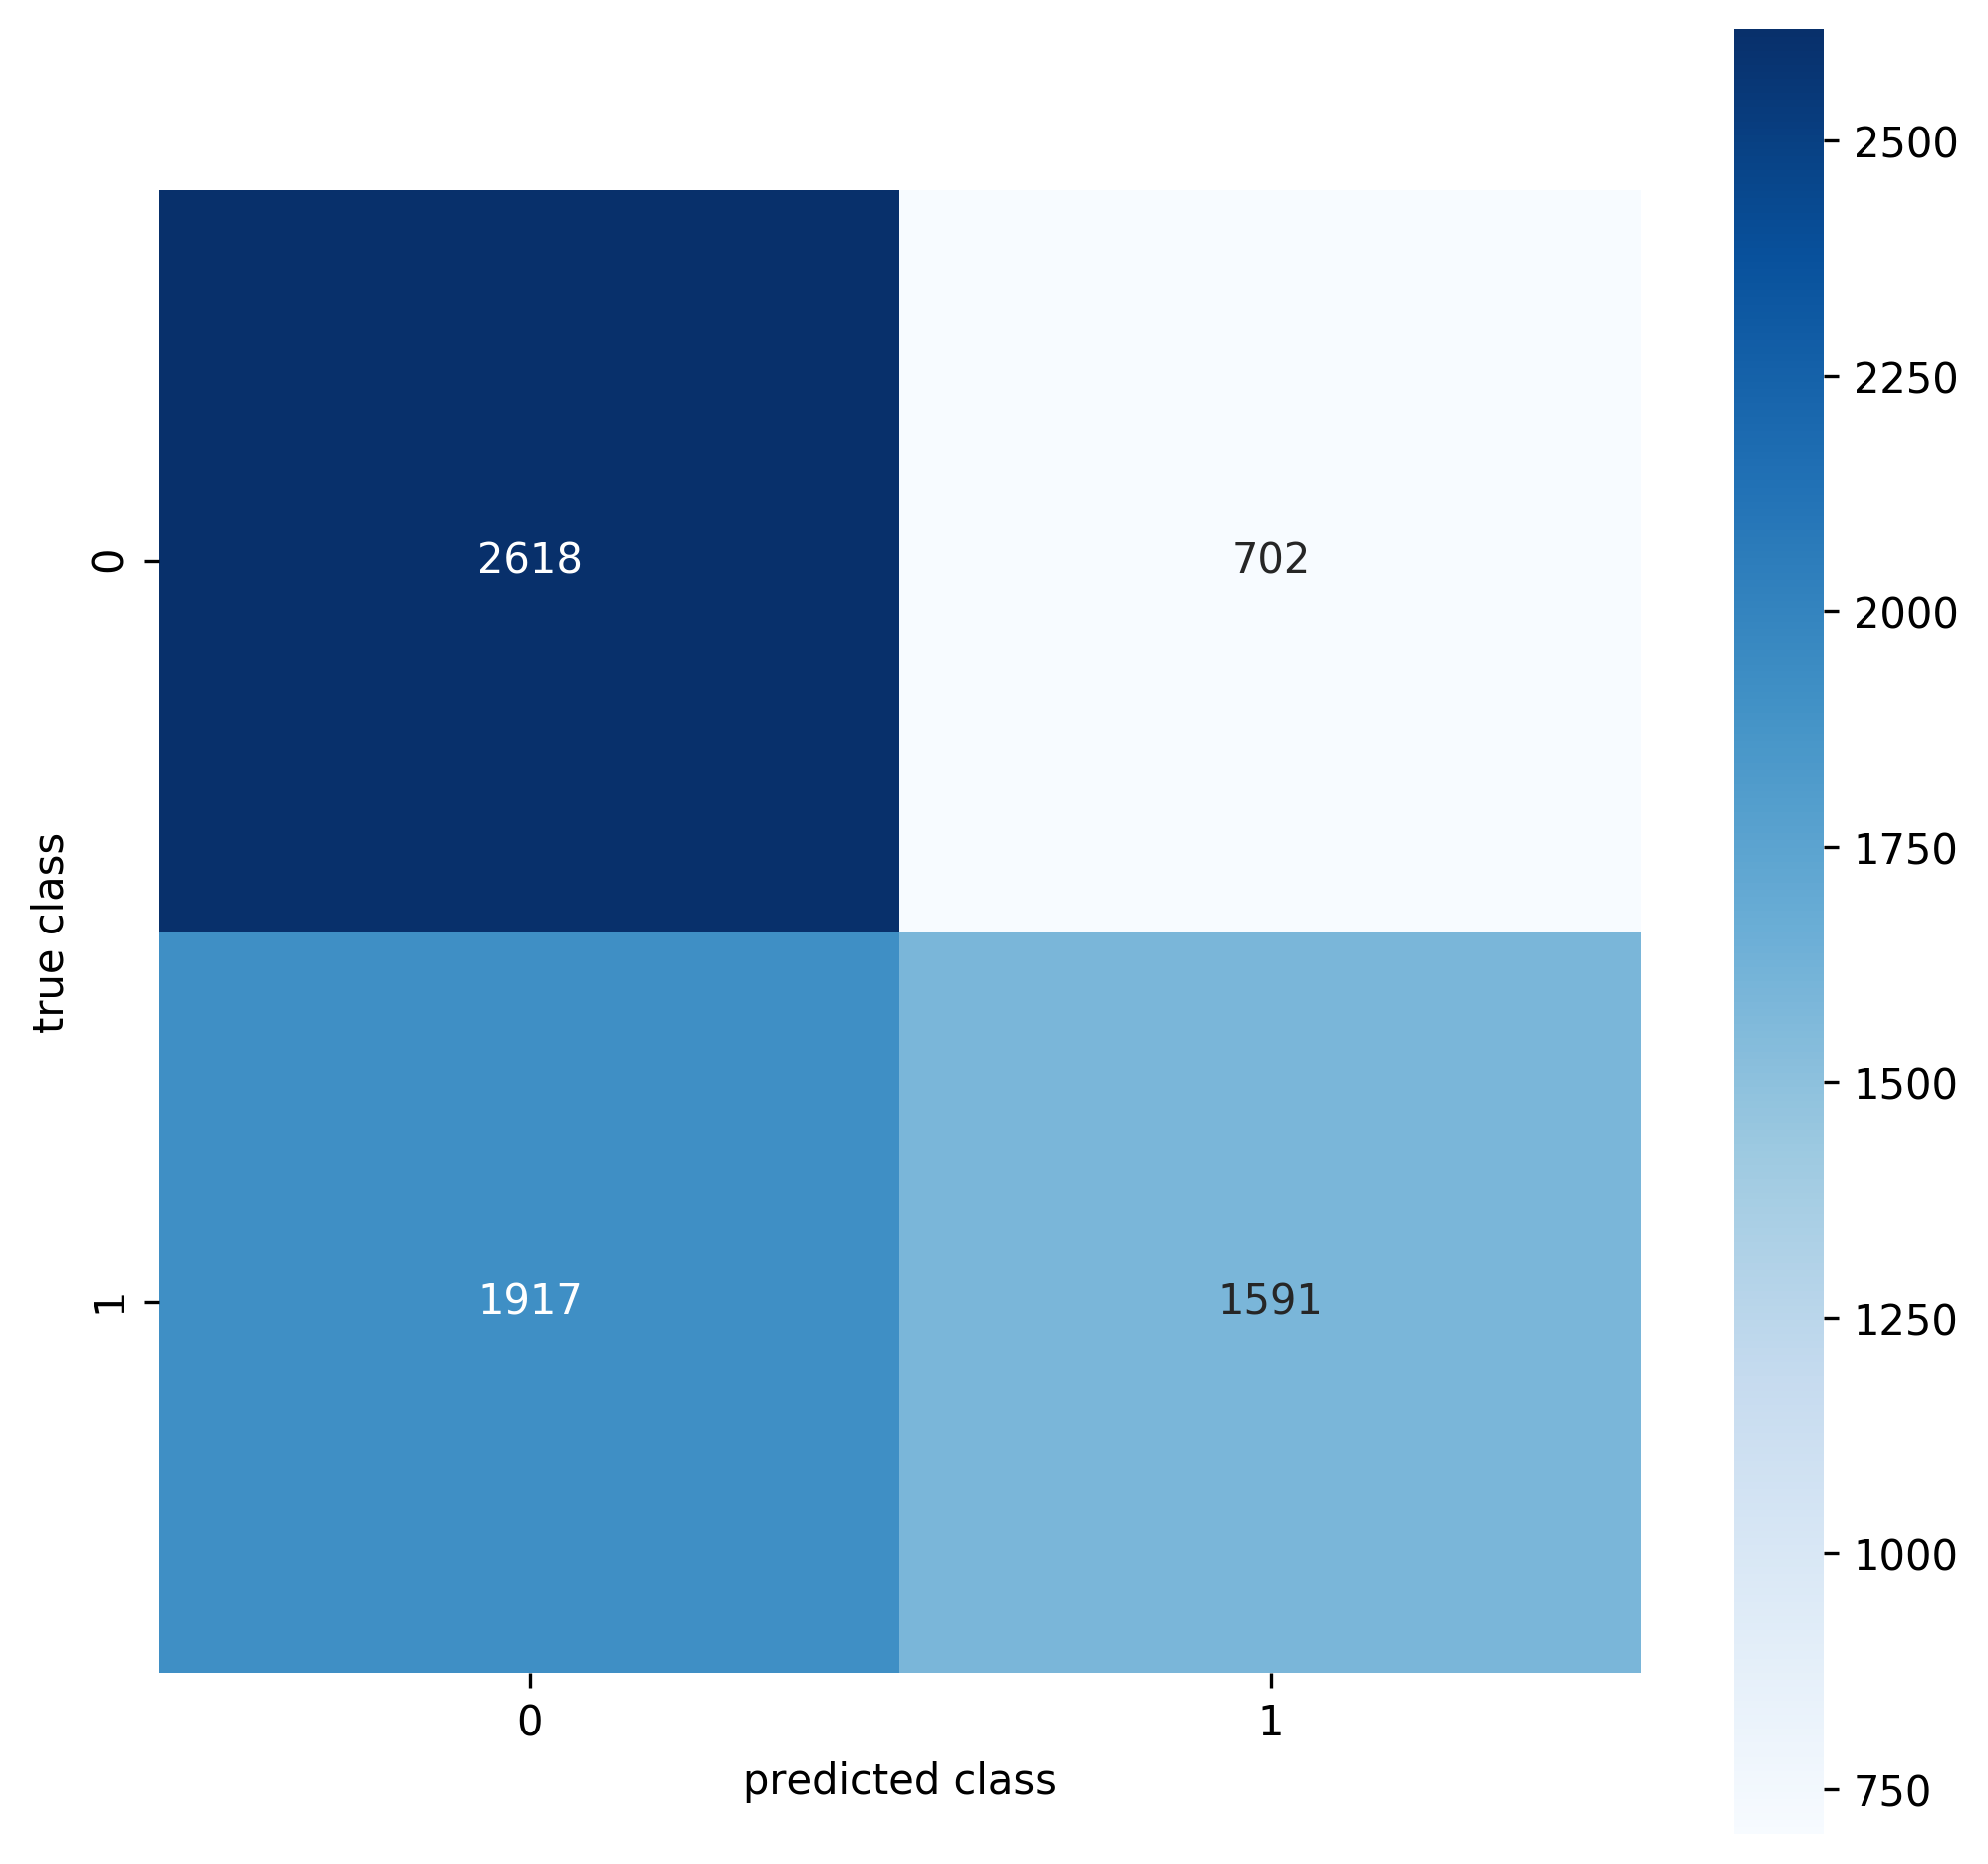

In [12]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=300)

sns.heatmap(
    confusion_matrix(running_targs_test, running_preds_test > 0.5),
    square=True, annot=True, fmt="d", cmap=plt.cm.Blues,
    ax=ax
)
ax.set_ylabel("true class")
ax.set_xlabel("predicted class")

In [ ]:
vgg.